In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irgiys","key":"7a52b5e62766e7a67d9074e33e4e46fa"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:45<00:00, 20.3MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.3MB/s]


In [ ]:
!rm -rf datasets
!mkdir datasets
!unzip -q chest-xray-pneumonia.zip -d chest-xray-pneumonia

!mv chest-xray-pneumonia/chest_xray/test datasets
!mv chest-xray-pneumonia/chest_xray/train datasets
!mv chest-xray-pneumonia/chest_xray/val datasets

!rm -rf chest-xray-pneumonia

In [ ]:
!kaggle datasets download -d samuel156/lungxrays-grayscale

Dataset URL: https://www.kaggle.com/datasets/samuel156/lungxrays-grayscale
License(s): unknown
100% 1.88G/1.89G [01:29<00:00, 22.7MB/s]
100% 1.89G/1.89G [01:29<00:00, 22.7MB/s]


In [ ]:
!unzip -q lungxrays-grayscale -d lungxrays-grayscale

!mv lungxrays-grayscale/LungXRays-grayscale/test/Corona\ Virus\ Disease datasets/test/COVID19
!mv lungxrays-grayscale/LungXRays-grayscale/train/Corona\ Virus\ Disease datasets/train/COVID19
!mv lungxrays-grayscale/LungXRays-grayscale/val/Corona\ Virus\ Disease datasets/val/COVID19

!mv lungxrays-grayscale/LungXRays-grayscale/test/Tuberculosis datasets/test/TUBERCULOSIS
!mv lungxrays-grayscale/LungXRays-grayscale/train/Tuberculosis datasets/train/TUBERCULOSIS
!mv lungxrays-grayscale/LungXRays-grayscale/val/Tuberculosis datasets/val/TUBERCULOSIS

!rm -rf lungxrays-grayscale

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2

Detect xray or non xray

In [ ]:
!mkdir -p xray_images

!mv /content/datasets/train/COVID19/* xray_images
!mv /content/datasets/train/NORMAL/* xray_images
!mv /content/datasets/train/PNEUMONIA/* xray_images
!mv /content/datasets/train/TUBERCULOSIS/* xray_images

In [ ]:
# scrape random images
# import requests
# import os

# # Folder output untuk gambar
# output_folder = "non_xray_images"
# os.makedirs(output_folder, exist_ok=True)

# # Jumlah gambar yang dibutuhkan
# jumlah_gambar = 1412  # untuk mencapai 1438 total
# width, height = 320, 240  # resolusi rendah

# for i in range(jumlah_gambar):
#     url = f"https://picsum.photos/{width}/{height}?random={i}"
#     response = requests.get(url)
#     with open(os.path.join(output_folder, f"image_{i}.jpg"), "wb") as file:
#         file.write(response.content)
#     print(f"Downloaded: image_{i}.jpg")

In [ ]:
!unzip -q -j non_xray_images.zip -d non_xray_images

In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 32

def load_data(data_dir, label):
    data = []
    for img_name in os.listdir(data_dir):
        try:
            img_path = os.path.join(data_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img_resized, label])
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data

In [ ]:
xray_dir = '/content/xray_images'
non_xray_dir = '/content/non_xray_images'

In [ ]:
xray_data = load_data(xray_dir, 1)  # Label for X-ray images: 1
non_xray_data = load_data(non_xray_dir, 0)  # Label for non-X-ray images: 0

num_xray = len(xray_data)
num_non_xray = len(non_xray_data)
if num_xray > num_non_xray:
    xray_data = random.sample(xray_data, num_non_xray)  # Sampling data X-ray

all_data = xray_data + non_xray_data

In [ ]:
np.random.shuffle(all_data)
X, y = zip(*all_data)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = Sequential([
    Conv2D(3, (1, 1), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

<ipython-input-17-acd3705dd9f7>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,087 (9.24 MB)

 Trainable params: 164,103 (641.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
#     validation_data=(X_val, y_val),
#     epochs=10,
#     callbacks=[learning_rate_reduction]
# )
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data = datagen.flow(X_val, y_val),
    epochs=10,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 325ms/step - accuracy: 0.9188 - loss: 1.8748 - val_accuracy: 0.9912 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9903 - loss: 0.4803 - val_accuracy: 0.9858 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9819 - loss: 0.2500 - val_accuracy: 0.9929 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9921 - loss: 0.1487 - val_accuracy: 0.9965 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9893 - loss: 0.1199 - val_accuracy: 0.9965 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 6/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9920 - loss: 0.0986
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9920 - loss: 0.0985 - val_accuracy: 

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation loss: {val_loss*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9997 - loss: 0.0378
Validation Accuracy: 99.82%
Validation loss: 4.04%


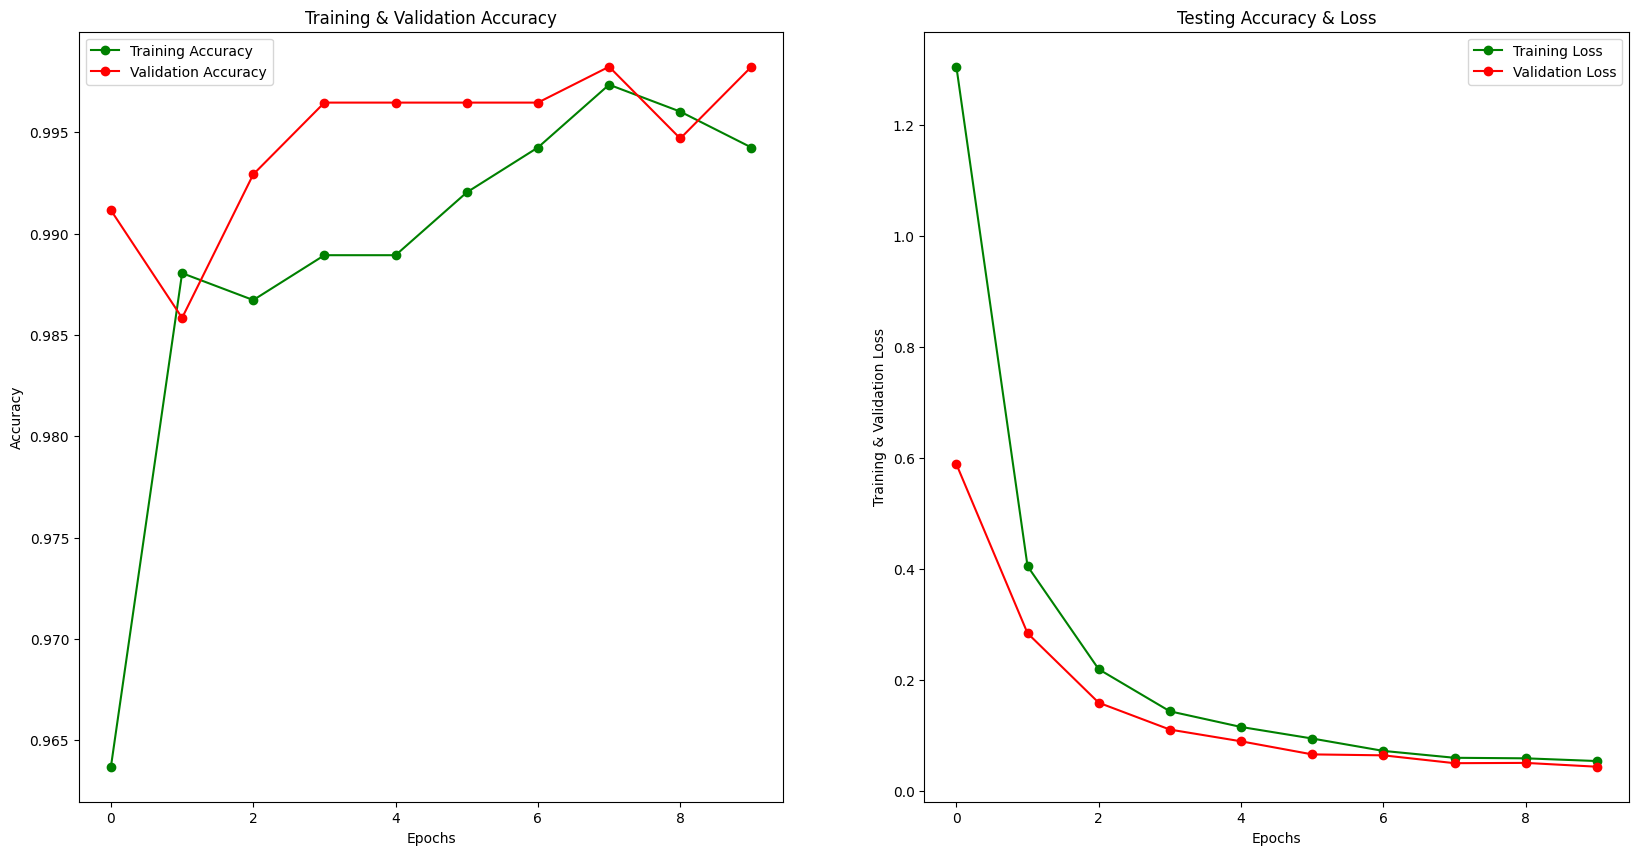

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i for i in range(len(train_acc))]

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(X_val) > 0.5).astype(int)  # Get binary predictions (0 or 1)
predictions = predictions.flatten()  # Flatten to a 1D array
print(classification_report(y_val, predictions, target_names=['Not X-ray', 'X-ray']))

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step
              precision    recall  f1-score   support

   Not X-ray       1.00      1.00      1.00       286
       X-ray       1.00      1.00      1.00       279

    accuracy                           1.00       565
   macro avg       1.00      1.00      1.00       565
weighted avg       1.00      1.00      1.00       565



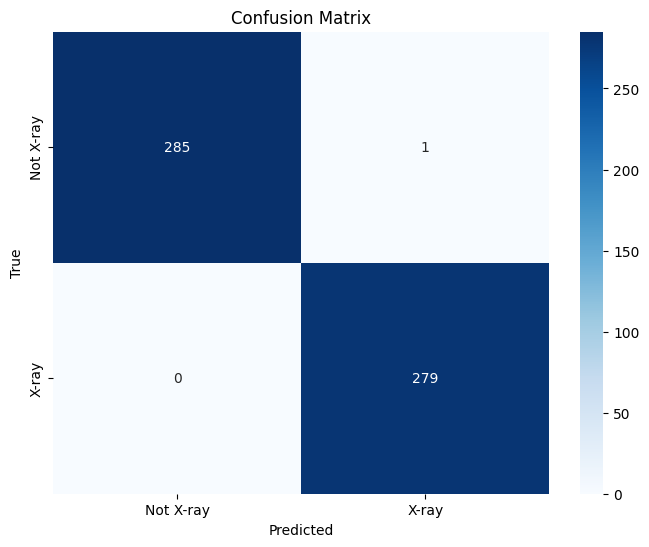

In [ ]:
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not X-ray', 'X-ray'],
            yticklabels=['Not X-ray', 'X-ray'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')⁸⁸⁶⁶
plt.show()

In [ ]:
def is_xray_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return "Error: Image not found"

    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img_reshaped)[0][0]
    print("confidence :", prediction)
    return "X-ray" if prediction >= 0.5 else "Not X-ray"

Saving 2.jpg to 2.jpg


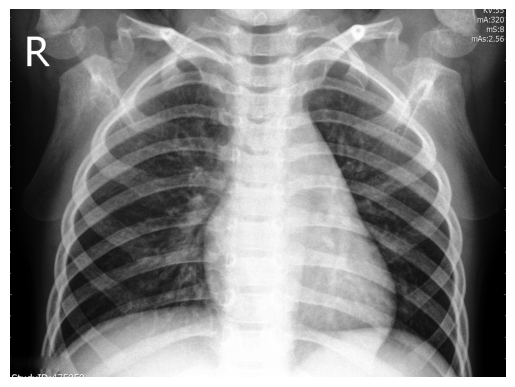

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
confidence : 0.9994154
The image is classified as: 
 ==== 
 X-ray


In [ ]:
from google.colab import files
uploaded = files.upload()

uploaded_image_path = "/content/" + str(list(uploaded.keys())[0])
# show uploaded image
plt.imshow(plt.imread(uploaded_image_path), cmap='gray')
plt.axis('off')
plt.show()
result = is_xray_image(uploaded_image_path, model)
print(f"The image is classified as: \n ==== \n {result}")

Saving 45.jpg to 45.jpg


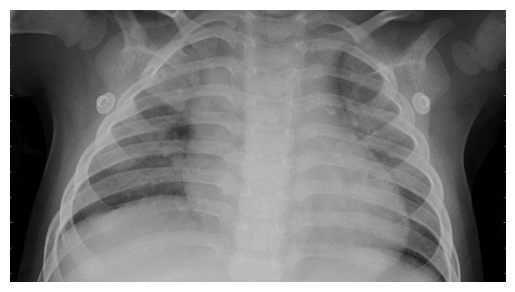

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
confidence : 0.99993527
The image is classified as: 
 ==== 
 X-ray


In [ ]:
from google.colab import files
uploaded = files.upload()

uploaded_image_path = "/content/" + str(list(uploaded.keys())[0])
# show uploaded image
plt.imshow(plt.imread(uploaded_image_path), cmap='gray')
plt.axis('off')
plt.show()
result = is_xray_image(uploaded_image_path, model)
print(f"The image is classified as: \n ==== \n {result}")

Saving Screenshot 2024-12-13 105056.png to Screenshot 2024-12-13 105056.png


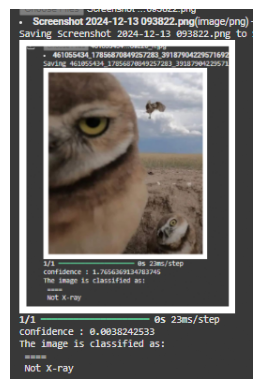

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
confidence : 0.0009632464
The image is classified as: 
 ==== 
 Not X-ray


In [ ]:
from google.colab import files
uploaded = files.upload()

uploaded_image_path = "/content/" + str(list(uploaded.keys())[0])
# show uploaded image
plt.imshow(plt.imread(uploaded_image_path), cmap='gray')
plt.axis('off')
plt.show()
result = is_xray_image(uploaded_image_path, model)
print(f"The image is classified as: \n ==== \n {result}")

Saving 465768996_1600403547543722_696610786000010850_n.jpg to 465768996_1600403547543722_696610786000010850_n.jpg


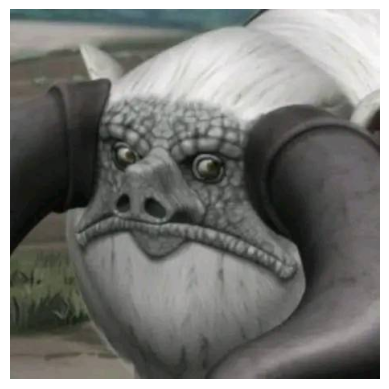

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
confidence : 0.0017570365
The image is classified as: 
 ==== 
 Not X-ray


In [ ]:
from google.colab import files
uploaded = files.upload()

uploaded_image_path = "/content/" + str(list(uploaded.keys())[0])
# show uploaded image
plt.imshow(plt.imread(uploaded_image_path), cmap='gray')
plt.axis('off')
plt.show()
result = is_xray_image(uploaded_image_path, model)
print(f"The image is classified as: \n ==== \n {result}")

In [ ]:
model.save('./isxray.keras')
model = tf.keras.models.load_model('./isxray.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []
tflite_model = converter.convert()
open("./isxray.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmp6f5bsn1l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134124552028224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124552005488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551999504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551925680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551924800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551923568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551924448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551922336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134124551917760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1341245519205

9517148